In [1]:
#Basic pre-reqs:
import numpy as np
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
version_nums = torch.__version__.split('.')
# Torch Geometric seems to always build for *.*.0 of torch :
version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
 
# %pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
# %pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
# %pip install --upgrade torch-geometric

In [4]:
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py -O models.py
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py -O simulate.py

--2024-06-20 15:06:22--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9647 (9,4K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   9,42K  --.-KB/s    in 0,001s  

2024-06-20 15:06:22 (14,2 MB/s) - ‘models.py’ saved [9647/9647]

--2024-06-20 15:06:23--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9752 (9,5K) [text/p

In [5]:
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 541.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import models
import simulate

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)


torch.ones(1).cuda()

True
2.3.1
12.1


tensor([1.], device='cuda:0')

In [2]:
# Number of simulations to run (it's fast, don't worry):
ns = 10000
# Potential (see below for options)
sim = 'r2'
# Number of nodes
n = 4
# Dimension
dim = 2
# Number of time steps
nt = 1000


#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

Running on r2_n=4_dim=2_nt=1000_dt=0.001


In [3]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

In [6]:
data = s.data
s.data.shape
print(s.data[0])

[[[ 2.0274465   0.12346178 -1.810647    0.26113966 -0.43152463
    0.7886358 ]
  [ 1.2941198  -0.5355589  -0.353034    1.442077   -0.40950936
    1.195086  ]
  [-2.172818    0.39194798 -1.5027773   0.87220526  0.49295962
    4.5856786 ]
  [ 0.16172081 -1.0134072   1.2195634  -0.68870366  1.0173919
    1.0502859 ]]

 [[ 2.0256314   0.12372299 -1.811991    0.26023373 -0.43152463
    0.7886358 ]
  [ 1.2937659  -0.5341137  -0.35341454  1.4424349  -0.40950936
    1.195086  ]
  [-2.1743236   0.39282188 -1.5025233   0.8721061   0.49295962
    4.5856786 ]
  [ 0.16294299 -1.014097    1.2198964  -0.6879975   1.0173919
    1.0502859 ]]

 [[ 2.0238152   0.12398329 -1.8133384   0.25932428 -0.43152463
    0.7886358 ]
  [ 1.2934116  -0.5326682  -0.35379276  1.4427931  -0.40950936
    1.195086  ]
  [-2.1758292   0.39369568 -1.5022697   0.8720071   0.49295962
    4.5856786 ]
  [ 0.1641655  -1.0147859   1.2202309  -0.6872901   1.0173919
    1.0502859 ]]

 ...

 [[ 1.067274   -0.15551677 -1.0301319  -0.7

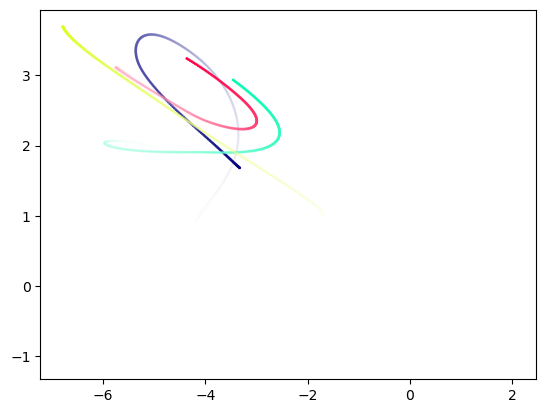

In [14]:
s.plot(0, animate=True, plot_size=False)

In [8]:
accel_data = s.get_acceleration()

In [9]:
X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)]))

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [11]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

In [12]:
aggr = 'add'
hidden = 300

test = '_l1_'

#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]

In [13]:

from torch_geometric.data import Data, DataLoader
from models import get_edge_index
edge_index = get_edge_index(n, sim)

In [14]:
if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

messages_over_time = []
ogn = ogn.cuda()

In [15]:
_q = Data(
    x=X_train[0].cuda(),
    edge_index=edge_index.cuda(),
    y=y_train[0].cuda())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

(tensor([[0.0594, 0.0429],
         [0.0555, 0.0486],
         [0.0893, 0.0562],
         [0.0593, 0.0467]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([4, 2]),
 torch.Size([4, 2]),
 tensor(24.8612, device='cuda:0', grad_fn=<SumBackward0>))

In [16]:
batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [18]:
def new_loss(self, g, augment=True, square=False):
    if square:
        return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
    else:
        base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
        if test in ['_l1_', '_kl_']:
            s1 = g.x[self.edge_index[0]]
            s2 = g.x[self.edge_index[1]]
            if test == '_l1_':
                m12 = self.message(s1, s2)
                regularization = 1e-2
                #Want one loss value per row of g.y:
                normalized_l05 = torch.sum(torch.abs(m12))
                return base_loss, regularization * batch * normalized_l05 / n**2 * n
            elif test == '_kl_':
                regularization = 1
                #Want one loss value per row of g.y:
                tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
                raw_msg = self.msg_fnc(tmp)
                mu = raw_msg[:, 0::2]
                logvar = raw_msg[:, 1::2]
                full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
                return base_loss, regularization * batch * full_kl / n**2 * n
        return base_loss

In [19]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 30


batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

5000

In [20]:
epoch = 0

In [21]:
from tqdm import tqdm
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

In [23]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

In [24]:
recorded_models = []
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cuda()
            ginput.y = ginput.y.cuda()
            ginput.edge_index = ginput.edge_index.cuda()
            ginput.batch = ginput.batch.cuda()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  0%|          | 0/30 [00:00<?, ?it/s]

12.469967523574828


  3%|▎         | 1/30 [00:59<28:53, 59.79s/it]

8.525172017145158


  7%|▋         | 2/30 [01:49<25:15, 54.11s/it]

6.354380544042587


 10%|█         | 3/30 [02:39<23:23, 52.00s/it]

5.294129695510864


 13%|█▎        | 4/30 [03:27<21:52, 50.47s/it]

4.417994521689415


 20%|██        | 6/30 [05:06<19:57, 49.89s/it]

3.3262302561283112


 23%|██▎       | 7/30 [05:55<19:01, 49.62s/it]

2.757613535451889
2.407042166852951


 30%|███       | 9/30 [07:32<17:05, 48.83s/it]

2.2563145238399507
2.0456637043476107


 33%|███▎      | 10/30 [08:20<16:14, 48.75s/it]

1.9106640397548675


 37%|███▋      | 11/30 [09:10<15:30, 48.98s/it]

1.735326480960846


 40%|████      | 12/30 [09:58<14:38, 48.79s/it]

1.6070787687897683


 43%|████▎     | 13/30 [10:45<13:41, 48.31s/it]

1.5009640310525894


 47%|████▋     | 14/30 [11:34<12:52, 48.30s/it]

1.3830697747826577


 53%|█████▎    | 16/30 [13:11<11:17, 48.38s/it]

1.2615226631879806
1.150602761632204


 57%|█████▋    | 17/30 [14:00<10:33, 48.70s/it]

1.0482497971594333


 60%|██████    | 18/30 [14:48<09:42, 48.50s/it]

0.9109815455079079


 63%|██████▎   | 19/30 [15:36<08:51, 48.29s/it]

0.8255058771193028


 67%|██████▋   | 20/30 [16:25<08:05, 48.58s/it]

0.7240678580641746


 70%|███████   | 21/30 [17:14<07:17, 48.62s/it]

0.6267353326380253


 73%|███████▎  | 22/30 [18:04<06:32, 49.02s/it]

0.5362142826974392


 77%|███████▋  | 23/30 [18:52<05:41, 48.77s/it]

0.46234017429947855


 80%|████████  | 24/30 [19:40<04:51, 48.65s/it]

0.39569137164652346


 83%|████████▎ | 25/30 [20:28<04:02, 48.46s/it]

0.34449145293831823


 90%|█████████ | 27/30 [22:05<02:25, 48.34s/it]

0.30432757743299005
0.2801502308487892


 97%|█████████▋| 29/30 [23:42<00:48, 48.52s/it]

0.26619034289717675
0.2574197000235319


100%|██████████| 30/30 [24:30<00:00, 49.02s/it]


In [25]:
import pickle as pkl
pkl.dump(messages_over_time,
    open('messages_over_time.pkl', 'wb'))
messages_over_time = pkl.load(open('messages_over_time.pkl', 'rb'))

pkl.dump(recorded_models,
    open('models_over_time.pkl', 'wb'))

recorded_models = pkl.load(open('models_over_time.pkl', 'rb'))

spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.2723333740234375
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.22928154839409726
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.17586914627640332
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.10929277208116318
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.045581373991789645
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.028321547331633393
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.016284729286476417
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.011901572192156757
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.00996651084334762
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.008631888142338505
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.00675423922362151
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.005399481808697736
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.005006443129645453
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.004782112262867115
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.004738812976413303
spring_n=4_dim=2_nt=1000_dt=0.01 _l1_ gets 0.00

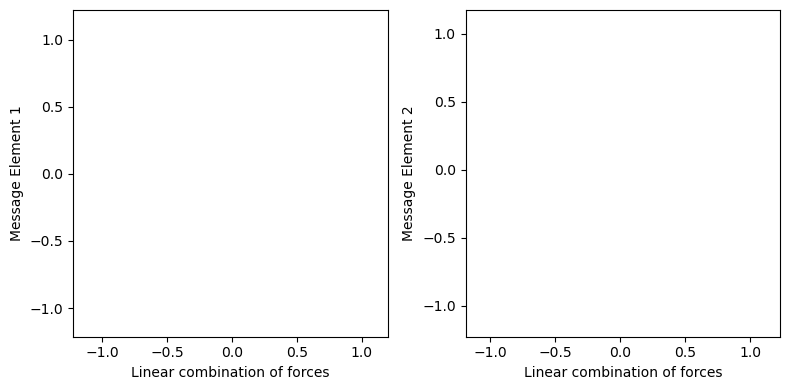

In [28]:
from celluloid import Camera
from copy import deepcopy as copy

#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        if sim != 'spring':
            raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        def force_fnc(msg):
            bd_array = msg['bd'].to_numpy()
            pos_array = msg[pos_cols].to_numpy()
            return -(bd_array - 1)[:, np.newaxis] * pos_array / bd_array[:, np.newaxis]

        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

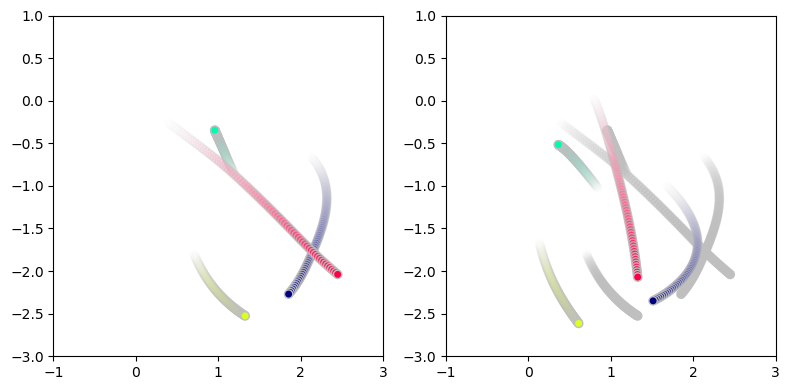

In [29]:
from simulate import make_transparent_color
from scipy.integrate import odeint
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
    i = 4 #Use this simulation
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    if current_model > -1:
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        y = y.reshape(4, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, 4, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()

# camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())

In [30]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

e56        dx        dy         r        m1        m2
0      0.054782  0.543488 -0.778920  0.949787  5.785905  0.836671
1      0.292349  1.947127  1.091559  2.232220  5.785905  0.770745
2      0.050658  0.818094 -0.411026  0.915544  5.785905  0.800204
3      0.027502 -0.543488  0.778920  0.949787  0.836671  5.785905
4      0.566911  1.403639  1.870479  2.338567  0.836671  0.770745
...         ...       ...       ...       ...       ...       ...
11995  0.116582  0.491158 -0.143346  0.511648  0.163864  0.695851
11996  0.057427  0.882843 -0.116667  0.890518  0.163864  1.765544
11997  0.315455  0.827243  1.477602  1.693411  1.765544  0.581951
11998  0.047133 -0.391685 -0.026679  0.392593  1.765544  0.695851
11999  0.034895 -0.882843  0.116667  0.890518  1.765544  0.163864

[12000 rows x 6 columns]